In [1]:
# Outlier data are the data that are out of the pattern more than a certain threshold.
# The outliers affect the machine learning model's performance, and therefore they shall be treated beforehand.
#
# There are a lot of ways to find the outliers, but I will use IQR (Interquartile Range) method.

## Interquartile Range (IQR)

![Interquartile Range](https://naysan.ca/wp-content/uploads/2020/06/box_plot_ref_needed.png)

The IQR is the range between Q1 and Q3. When using IQR to find the outliers, we first multiply a certain factor (usually 1.5, but it can be any value) to the IQR. Then, subtract the value from the Q1 value and add the value to the Q3 value. Each of these added/subtracted values will be the standard of determining whether a value is an outlier.

If a value is out of the range set by the standards, the value is determined as an outlier.

<AxesSubplot:>

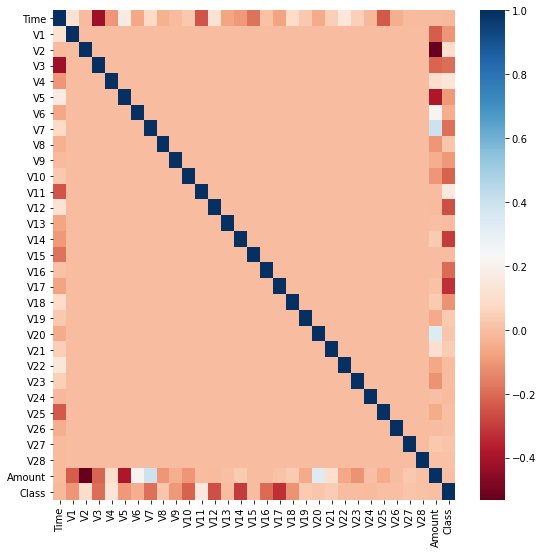

In [3]:
# First, before using IQR, analyse the featrues.

# If there are lots of features, the good way to find the outliers is to use the features with higher importance
# for the determination of outliers.

# If there are lots of features it will take a long time to search all the features and their outliers, and also if
# the feature's importance is not very high, removing the outliers would not result in a meaningful increase in
# the performance of the model.

# I will use DataFrame's corr to find the correlation of the features and visualise them using Seaborn's heatmap.
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import pandas as pd

card_df = pd.read_csv("./creditcard.csv")

plt.figure(figsize=(9, 9))
corr = card_df.corr()
# The RdBu cmap (colormap) illustrates the correlation by expressing the positive correlations with blue colour and
# the negative correlations with red colour. The redder the colour is, the more negative the correlation is, and
# vice versa.
sns.heatmap(corr, cmap='RdBu')

With class, `V14` and `V17` features had the most negative correlations amongst the features.

In [8]:
# We will find the outliers of V14. The function below finds the outliers.
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # Extract the data that has class value of "fraud", and get the Q1 and Q3 values using np.percetile
    fraud = df[df['Class']==1][column]
    
    q1 = np.percentile(fraud.values, 25)
    q3 = np.percentile(fraud.values, 75)
    iqr = q3 - q1
    iqr_weight = iqr * weight
    lowest_val = q1 - iqr_weight
    highest_val = q3 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [9]:
# Test the function
outlier_index = get_outlier(df=card_df, column="V14", weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


4 data are spotted to be the outliers. Now, preprocess the dataframe to remove the outliers.

In [10]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # do log scaling
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    # add logic to remove the outliers
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [13]:
######## UTILS ##########
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [16]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

from sklearn.linear_model import LogisticRegression
print("로지스틱 회귀 성능")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

from lightgbm import LGBMClassifier
print("LGBM 예측 성능")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 성능
오차행렬
 [[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
LGBM 예측 성능
오차행렬
 [[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC: 0.9780


### Result

Removing the outlier data has improved the model performance highly. The LogisticRegression classifier's recall value has improved from 60.14% to 0.6712%, and the LGBMClassifier's recall value has improved from 76.35% to 82.88%.